In [1]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

In [17]:
def parse_describe_result(describe_str):
    # Remove the 'DescribeResult(' and trailing ')' parts, then split by commas
    cleaned_str = describe_str.replace('DescribeResult(', '').replace(')', '').replace('(', '').replace(')', '').replace(' ','')
    parts = cleaned_str.split(',')
    min_val = float(parts[1].split('=')[1].strip())
    max_val = float(parts[2])
    mean_val = float(parts[3].split('=')[1].strip())
    variance_val = float(parts[4].split('=')[1].strip())
    return pd.Series({'Min': min_val, 'Max': max_val, 'Mean': mean_val, 'Variance': variance_val})



In [39]:
result_file_directory = "../results/experiment3 20240827-1605.csv"
df = pd.read_csv(result_file_directory)
unique_data = df['Data'].unique()

for data_value in unique_data:
    filtered_df = df[df['Data'] == data_value][["Method","Measure","Value"]]
    table_1_filtered = filtered_df[filtered_df['Measure'].isin(['ambiguity', 'discrepancy'])].pivot(index='Method', columns='Measure', values='Value')
    display(HTML(f"<h5>Table for {data_value} Ambiguity and Discrepancy</h5>"))
    display(HTML(f"{table_1_filtered.to_html()}"))
    display(HTML(f"<h5>Table for {data_value} Variance in Predictions</h5>"))
    table_2 = filtered_df[filtered_df['Measure'] == 'variance in predictions']['Value'].apply(parse_describe_result)
    table_2.index = filtered_df[filtered_df['Measure'] == 'variance in predictions']['Method']
    display(HTML(f"{table_2.to_html()}"))
    display(HTML(f"<h5>Table for {data_value} Disagreements</h5>"))
    table_3 = filtered_df[filtered_df['Measure'] == 'disagreement']['Value'].apply(parse_describe_result)
    table_3.index = filtered_df[filtered_df['Measure'] == 'disagreement']['Method']
    display(HTML(f"{table_3.to_html()}"))


Measure,ambiguity,discrepancy
Method,,
M,0.21,0.136
a,0.23,0.136
b,0.197,0.114
c,0.185,0.117
d,0.145,0.097


,Min,Max,Mean,Variance
Method,,,,
M,0.000407,0.047625,0.005499,0.000052
a,0.000374,0.023252,0.003747,0.000011
b,0.000020,0.022602,0.002709,0.000010
c,0.000417,0.035491,0.003958,0.000017
d,0.000085,0.031793,0.003529,0.000012


,Min,Max,Mean,Variance
Method,,,,
M,0.0,0.090226,0.031146,0.001018
a,0.0,0.091479,0.017809,0.000373
b,0.0,0.091479,0.014160,0.000306
c,0.0,0.058897,0.018956,0.000242
d,0.0,0.037594,0.014536,0.000234


Measure,ambiguity,discrepancy
Method,,
M,0.408,0.309
a,0.368,0.225
b,0.287,0.189
c,0.264,0.169
d,0.154,0.134


,Min,Max,Mean,Variance
Method,,,,
M,0.000826,0.157337,0.019928,0.000443
a,0.000445,0.078187,0.009176,0.000094
b,0.000078,0.077059,0.007284,0.000094
c,0.000331,0.105521,0.009749,0.000121
d,0.000009,0.104731,0.006354,0.000179


,Min,Max,Mean,Variance
Method,,,,
M,0.0,0.352227,0.130870,0.009763
a,0.0,0.268016,0.063720,0.002095
b,0.0,0.183806,0.051690,0.001332
c,0.0,0.159109,0.065171,0.002547
d,0.0,0.094332,0.035975,0.001304


Measure,ambiguity,discrepancy
Method,,
M,0.467,0.365
a,0.335,0.185
b,0.275,0.151
c,0.199,0.146
d,0.194,0.127


,Min,Max,Mean,Variance
Method,,,,
M,0.002104,0.163421,0.025126,0.000207
a,0.000013,0.105181,0.009020,0.000102
b,0.000015,0.088697,0.008069,0.000084
c,0.000013,0.092786,0.007128,0.000084
d,0.000015,0.087859,0.007012,0.000095


,Min,Max,Mean,Variance
Method,,,,
M,0.0,0.404453,0.149117,0.016378
a,0.0,0.173512,0.059188,0.001732
b,0.0,0.173512,0.054427,0.001690
c,0.0,0.132975,0.045641,0.001928
d,0.0,0.107793,0.045580,0.001507


In [24]:
df = pd.read_csv('../results/experiment3 final.csv')
df['Data'] = df['Data'].str.replace('_Data$', '', regex=True)
df['Data'] = df['Data'].str.replace('_', ' ', regex=True)
# df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

In [14]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools

# Assuming df is your DataFrame with columns 'method' and 'MSE'
methods = df['Method'].unique()

# Initialize dictionary to store results
confidence_level = 0.95
subset_data = df[(df['Measure'] == 'ambiguity')]
# Initialize a list to store the results for table creation
pairwise_results = []
for method in methods:
    if method != 'M':
        # Filter MSE values for "sequential reconcile" and the current method
        mse_sequential = subset_data[subset_data['Method'] == 'M']['Value']
        mse_method = subset_data[subset_data['Method'] == method]['Value']
        
        # Perform a two-sided t-test (since we are computing confidence intervals)
        t_stat, p_value = stats.ttest_ind(mse_sequential, mse_method)
        
        # Calculate the difference in means
        mean_diff = np.mean(mse_sequential) - np.mean(mse_method)
        
        # Calculate the standard error of the difference in means
        se_diff = np.sqrt(np.var(mse_sequential, ddof=1) / len(mse_sequential) + 
                          np.var(mse_method, ddof=1) / len(mse_method))
        
        # Get the degrees of freedom
        dof = len(mse_sequential) + len(mse_method) - 2
        
        # Find the critical t-value for the confidence level
        t_critical = stats.t.ppf((1 + confidence_level) / 2, df=dof)
        
        # Calculate the margin of error
        margin_of_error = t_critical * se_diff
        
        # Calculate the confidence interval
        ci_lower = mean_diff - margin_of_error
        ci_upper = mean_diff + margin_of_error
        
        # Store the results in a dictionary for table creation
        pairwise_results.append({
            'Method Compared': method,
            'Mean Difference': mean_diff,
            'T-statistic': t_stat,
            'P-value': p_value,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper
        })

# Convert results to a pandas DataFrame for table format
results_df = pd.DataFrame(pairwise_results)

# Display the table in Jupyter
display(results_df)

,Method Compared,T-statistic,P-value,Mean Difference,CI Lower,CI Upper
0,a,8.432584,8.310740e-17,0.045571,0.034970,0.056173
1,b,20.452981,1.514357e-81,0.105000,0.094929,0.115071
2,c,28.975258,5.724010e-145,0.143067,0.133381,0.152753
3,d,41.777737,3.060368e-248,0.202410,0.192906,0.211914


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     M      a  -0.0456   0.0 -0.0571  -0.034   True
     M      b   -0.105   0.0 -0.1165 -0.0935   True
     M      c  -0.1431   0.0 -0.1546 -0.1315   True
     M      d  -0.2024   0.0 -0.2139 -0.1909   True
     a      b  -0.0594   0.0  -0.071 -0.0479   True
     a      c  -0.0975   0.0  -0.109  -0.086   True
     a      d  -0.1568   0.0 -0.1684 -0.1453   True
     b      c  -0.0381   0.0 -0.0496 -0.0265   True
     b      d  -0.0974   0.0 -0.1089 -0.0859   True
     c      d  -0.0593   0.0 -0.0709 -0.0478   True
---------------------------------------------------


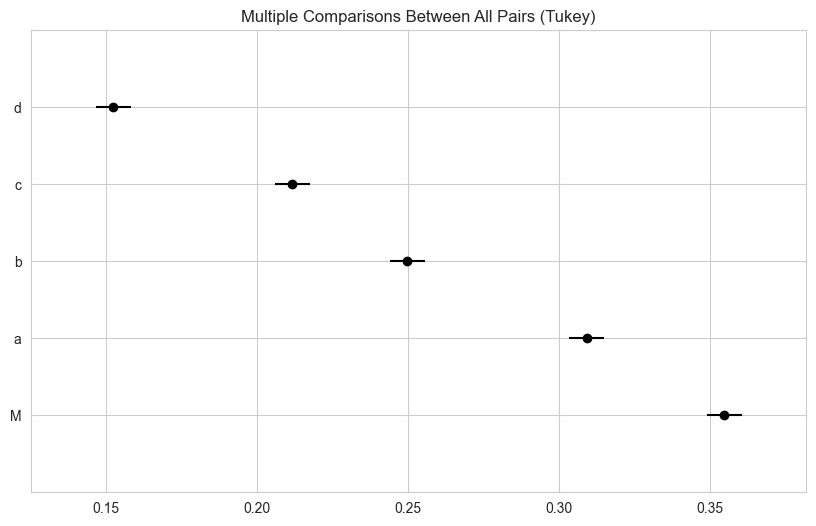

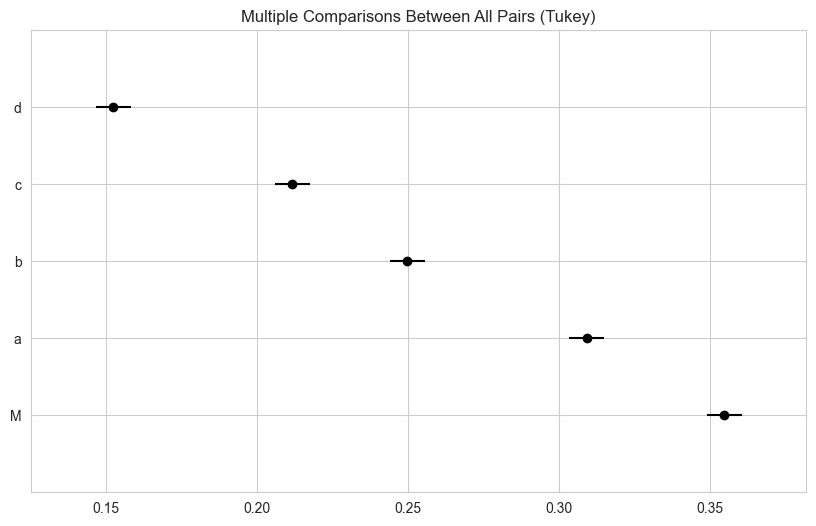

In [16]:
subset_data = df[(df['Measure'] == 'ambiguity')]
# print(subset_data.groupby('Method').mean(['Value']))
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=subset_data['Value'], groups=subset_data['Method'], alpha=0.05)

print(tukey.summary())
tukey.plot_simultaneous()

In [5]:
subset_data = df[df['Measure'] == 'discrepancy']
subset_data['Value'] = pd.to_numeric(subset_data['Value'], errors='coerce')
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test for pairwise comparisons between all methods
tukey = pairwise_tukeyhsd(endog=subset_data['Value'], groups=subset_data['Method'], alpha=0.05)

# Print Tukey HSD results
print(tukey)

/var/folders/v_/d3hz__gx7y9ffy_rls7zbjpm0000gn/T/ipykernel_34279/231113942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Value'] = pd.to_numeric(subset_data['Value'], errors='coerce')


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     M      a  -0.0806   0.0 -0.0883 -0.0729   True
     M      b  -0.1059   0.0 -0.1136 -0.0982   True
     M      c  -0.1205   0.0 -0.1282 -0.1128   True
     M      d  -0.1486   0.0 -0.1563 -0.1409   True
     a      b  -0.0253   0.0  -0.033 -0.0176   True
     a      c  -0.0399   0.0 -0.0476 -0.0322   True
     a      d   -0.068   0.0 -0.0757 -0.0603   True
     b      c  -0.0147   0.0 -0.0224  -0.007   True
     b      d  -0.0427   0.0 -0.0504  -0.035   True
     c      d  -0.0281   0.0 -0.0358 -0.0204   True
---------------------------------------------------


In [25]:
tab = df[df['Measure'] == 'variance in predictions']['Value'].apply(parse_describe_result)
df_subset = df[df['Measure'] == 'variance in predictions']
df_subset['Min'], df_subset['Max'], df_subset['Mean'], df_subset['var'] = tab['Min'], tab['Max'], tab['Mean'], tab['Variance']

/var/folders/v_/d3hz__gx7y9ffy_rls7zbjpm0000gn/T/ipykernel_79407/2607851901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Min'], df_subset['Max'], df_subset['Mean'], df_subset['var'] = tab['Min'], tab['Max'], tab['Mean'], tab['Variance']
/var/folders/v_/d3hz__gx7y9ffy_rls7zbjpm0000gn/T/ipykernel_79407/2607851901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Min'], df_subset['Max'], df_subset['Mean'], df_subset['var'] = tab['Min'], tab['Max'], tab['Mean'], tab['Variance']
/v

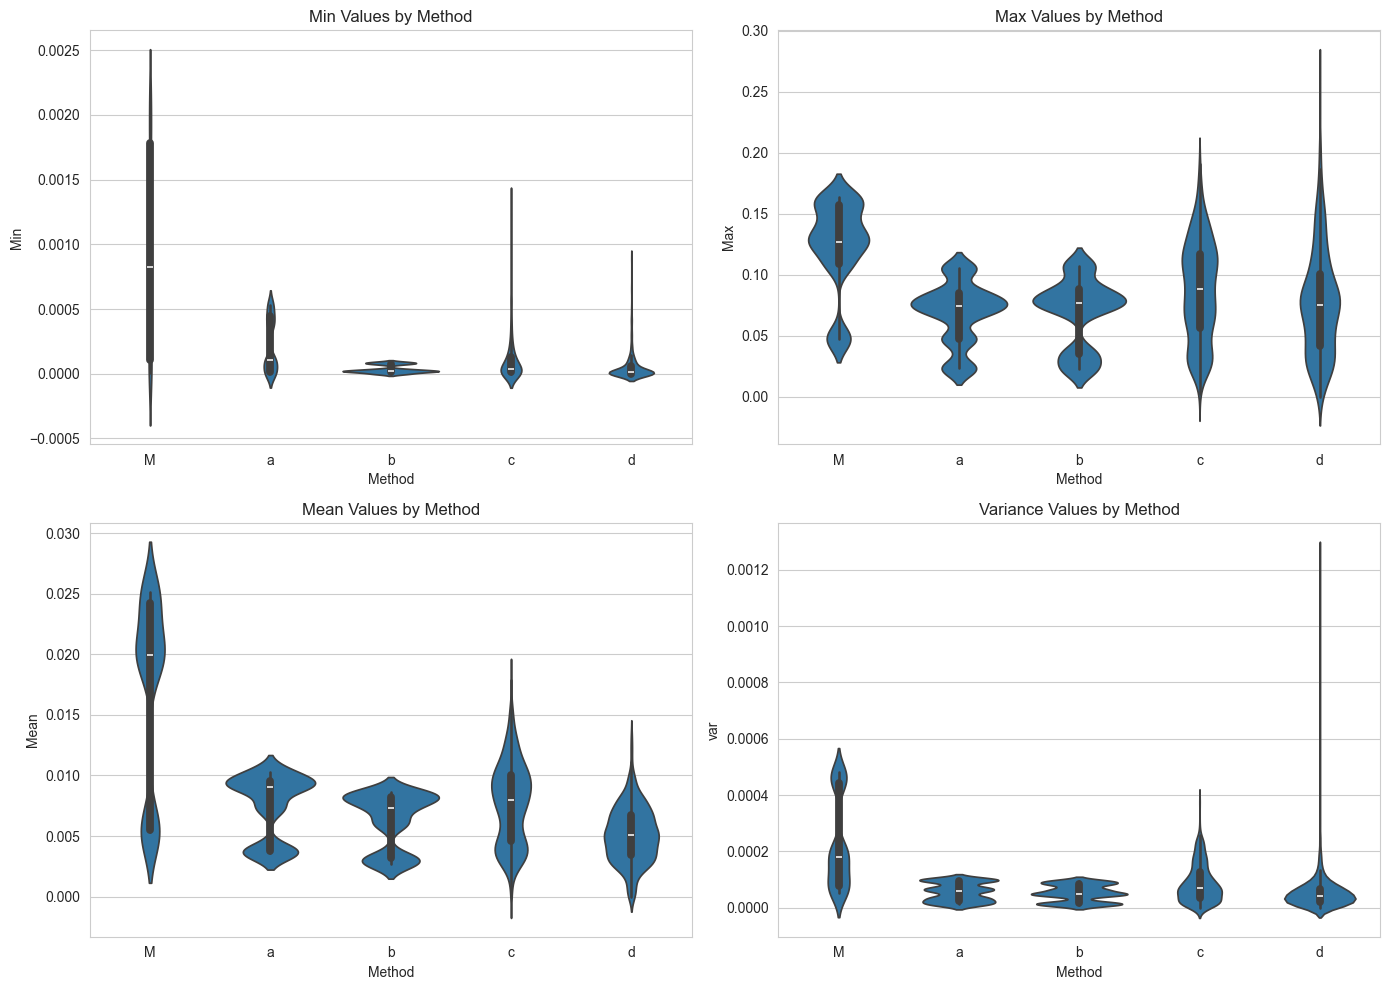

In [35]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Violin plot for 'min'
sns.violinplot(ax=axes[0, 0], x='Method', y='Min', data=df_subset)
axes[0, 0].set_title('Min Values by Method')

# Violin plot for 'max'
sns.violinplot(ax=axes[0, 1], x='Method', y='Max', data=df_subset)
axes[0, 1].set_title('Max Values by Method')

# Violin plot for 'mean'
sns.violinplot(ax=axes[1, 0], x='Method', y='Mean', data=df_subset)
axes[1, 0].set_title('Mean Values by Method')

# Violin plot for 'variance'
sns.violinplot(ax=axes[1, 1], x='Method', y='var', data=df_subset)
axes[1, 1].set_title('Variance Values by Method')

# Adjust layout
# plt.title("Variance in Predictions Statistics Across Methods")
plt.tight_layout()
plt.show()

/var/folders/v_/d3hz__gx7y9ffy_rls7zbjpm0000gn/T/ipykernel_79407/2546112722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Min'], df_subset['Max'], df_subset['Mean'], df_subset['var'] = tab['Min'], tab['Max'], tab['Mean'], tab['Variance']
/var/folders/v_/d3hz__gx7y9ffy_rls7zbjpm0000gn/T/ipykernel_79407/2546112722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Min'], df_subset['Max'], df_subset['Mean'], df_subset['var'] = tab['Min'], tab['Max'], tab['Mean'], tab['Variance']
/v

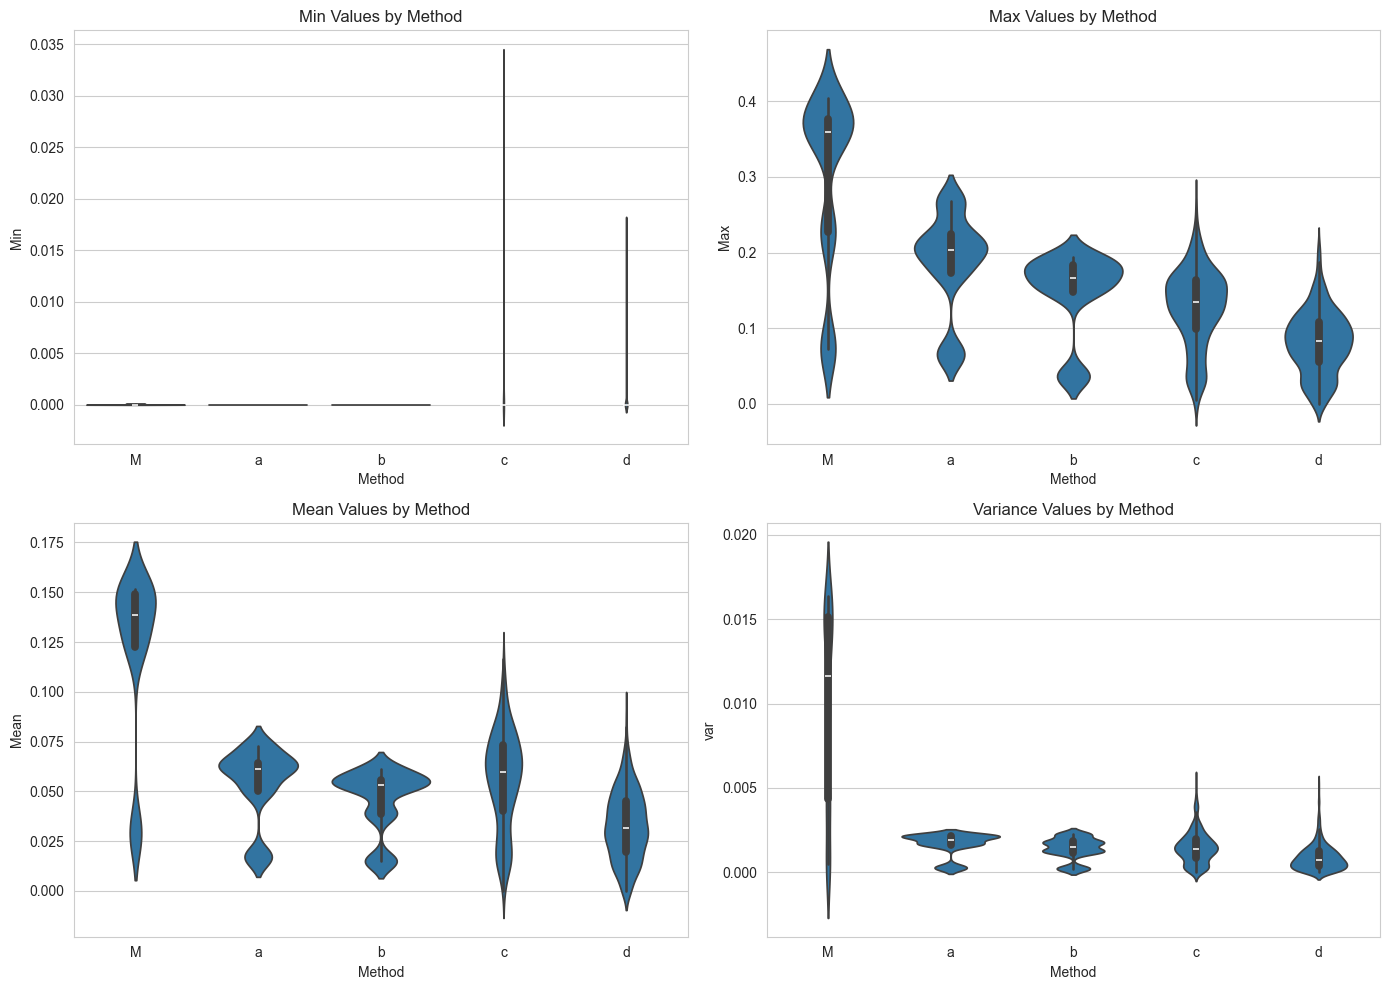

In [37]:
tab = df[(df['Measure'] == 'disagreement') & (df['Data'] != 'Community')]['Value'].apply(parse_describe_result)
df_subset = df[(df['Measure'] == 'disagreement') & (df['Data'] != 'Community')]
df_subset['Min'], df_subset['Max'], df_subset['Mean'], df_subset['var'] = tab['Min'], tab['Max'], tab['Mean'], tab['Variance']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Violin plot for 'min'
sns.violinplot(ax=axes[0, 0], x='Method', y='Min', data=df_subset)
axes[0, 0].set_title('Min Values by Method')

# Violin plot for 'max'
sns.violinplot(ax=axes[0, 1], x='Method', y='Max', data=df_subset)
axes[0, 1].set_title('Max Values by Method')

# Violin plot for 'mean'
sns.violinplot(ax=axes[1, 0], x='Method', y='Mean', data=df_subset)
axes[1, 0].set_title('Mean Values by Method')

# Violin plot for 'variance'
sns.violinplot(ax=axes[1, 1], x='Method', y='var', data=df_subset)
axes[1, 1].set_title('Variance Values by Method')

# Adjust layout
plt.tight_layout()
plt.show()